In [29]:
#!pip3 install -q numpy pandas catboost hyperopt scikit-learn frozendict matplotlib

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
#Initial code used from https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/
 # and parameter search from https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html

import catboost as cb
import numpy as np
import numpy.random as nr
import pandas as pd
import catboost.utils as cbu
import hyperopt
import sys
import sklearn.model_selection as ms

import sklearn.metrics as sklm

from frozendict import frozendict
%matplotlib inline

# print module versions for reproducibility
print('CatBoost version {}'.format(cb.__version__))
print('NumPy version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))

CatBoost version 0.14.2
NumPy version 1.16.2
Pandas version 0.24.2


In [4]:
# Load already prepared training dataset, display shape, & explore first 10 rows of Pandas data frame

train_set = pd.read_csv('LoanTrain_Clean_2019-04-23-A2e2aRed.csv')
print(train_set.shape)
train_set.head()

(500000, 23)


,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,ffiecmedian_family_income,lender,co_applicant,accepted,LTI,RaceGroup,log(x+1)_loan_amount,log(x+1)_LTI,log(x+1)_applicant_income,log(x+1)_minority_population_pct
0,3,1,1,1,70,3,18,37,246,2,...,60588,4536,False,1,2.916667,5,4.262680,1.365241,3.218876,3.811761
1,1,1,3,1,178,3,369,52,299,1,...,54821,2458,False,0,3.122807,5,5.187386,1.416534,4.060443,2.827609
2,2,1,3,1,163,3,16,10,306,2,...,67719,5710,False,1,2.432836,5,5.099866,1.233387,4.219508,4.131480
3,1,1,1,1,155,1,305,47,180,2,...,78439,5888,True,1,1.476190,5,5.049856,0.906721,4.663439,1.980450
4,1,1,1,1,305,3,24,37,20,2,...,63075,289,False,1,4.295775,3,5.723585,1.666909,4.276666,4.615121


In [5]:
# Testing for Class Imbalance by Examining Classes where label= accepted
 # Unequal numbers of cases for the categories of labels, which can seriously bias the training of classifier alogrithms 
 #  higher error rate for the minority class. This should be tested for before training any model.   

train_set_counts = train_set[['loan_type','accepted']].groupby('accepted').count()
print(train_set_counts)

          loan_type
accepted           
0            249886
1            250114


In [6]:
#Load test data previously prepared in data preparation step.

test_set = pd.read_csv('LoanTest_Clean_2019-04-23-A2w2aRed.csv')
print(test_set.shape)
test_set.head()

(500000, 22)


,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_income,ffiecmedian_family_income,lender,co_applicant,LTI,RaceGroup,log(x+1)_loan_amount,log(x+1)_LTI,log(x+1)_applicant_income,log(x+1)_minority_population_pct
0,2,1,3,1,115,3,101,16,276,2,...,74,69889,3791,True,1.554054,5,4.753590,0.937682,4.317488,4.103238
1,1,1,1,1,252,2,87,20,68,2,...,107,65313,2839,True,2.355140,5,5.533389,1.210494,4.682131,2.202765
2,1,1,1,1,270,1,-1,-1,-1,2,...,119,67514,4701,False,2.268908,1,5.602119,1.184456,4.787492,3.176177
3,2,1,1,1,179,2,376,20,11,2,...,44,57766,2153,True,4.068182,2,5.192957,1.622982,3.806662,3.423481
4,2,1,1,1,36,2,254,48,156,3,...,32,63332,5710,False,1.125000,6,3.610918,0.753772,3.496508,1.809927


In [7]:
# Check training data types

train_set.dtypes

loan_type                             int64
property_type                         int64
loan_purpose                          int64
occupancy                             int64
loan_amount                           int64
preapproval                           int64
msa_md                                int64
state_code                            int64
county_code                           int64
applicant_ethnicity                   int64
applicant_race                        int64
applicant_sex                         int64
applicant_income                      int64
ffiecmedian_family_income             int64
lender                                int64
co_applicant                           bool
accepted                              int64
LTI                                 float64
RaceGroup                             int64
log(x+1)_loan_amount                float64
log(x+1)_LTI                        float64
log(x+1)_applicant_income           float64
log(x+1)_minority_population_pct

In [8]:
# Check test data types

test_set.dtypes

loan_type                             int64
property_type                         int64
loan_purpose                          int64
occupancy                             int64
loan_amount                           int64
preapproval                           int64
msa_md                                int64
state_code                            int64
county_code                           int64
applicant_ethnicity                   int64
applicant_race                        int64
applicant_sex                         int64
applicant_income                      int64
ffiecmedian_family_income             int64
lender                                int64
co_applicant                           bool
LTI                                 float64
RaceGroup                             int64
log(x+1)_loan_amount                float64
log(x+1)_LTI                        float64
log(x+1)_applicant_income           float64
log(x+1)_minority_population_pct    float64
dtype: object

In [9]:
#Creating a training set for modeling and validation set to check model performance


train_set = train_set.drop('accepted', axis=1) # remove labels

In [10]:
# ReCheck training data types

train_set.dtypes

loan_type                             int64
property_type                         int64
loan_purpose                          int64
occupancy                             int64
loan_amount                           int64
preapproval                           int64
msa_md                                int64
state_code                            int64
county_code                           int64
applicant_ethnicity                   int64
applicant_race                        int64
applicant_sex                         int64
applicant_income                      int64
ffiecmedian_family_income             int64
lender                                int64
co_applicant                           bool
LTI                                 float64
RaceGroup                             int64
log(x+1)_loan_amount                float64
log(x+1)_LTI                        float64
log(x+1)_applicant_income           float64
log(x+1)_minority_population_pct    float64
dtype: object

In [11]:
# ReCheck test data types

test_set.dtypes

loan_type                             int64
property_type                         int64
loan_purpose                          int64
occupancy                             int64
loan_amount                           int64
preapproval                           int64
msa_md                                int64
state_code                            int64
county_code                           int64
applicant_ethnicity                   int64
applicant_race                        int64
applicant_sex                         int64
applicant_income                      int64
ffiecmedian_family_income             int64
lender                                int64
co_applicant                           bool
LTI                                 float64
RaceGroup                             int64
log(x+1)_loan_amount                float64
log(x+1)_LTI                        float64
log(x+1)_applicant_income           float64
log(x+1)_minority_population_pct    float64
dtype: object

In [12]:
# Now, you’ll see that we will only identify categorical variables. We will not perform any preprocessing steps for 
 # categorical variables:

categorical_features_indices = np.where(train_set.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17])

In [13]:
# Convert datasets to numpy arrays
 # Load training labels

train_set = np.array(train_set)
test_set = np.array(test_set)

l = pd.read_csv('April_DAT102x_TrainingLabels_2019-04-01.csv')
labels = np.array(l['accepted'])
print(labels.shape)
labels[:5]

(500000,)


array([1, 0, 1, 1, 1])

In [14]:
# Check labels

print(labels)

[1 0 1 ... 0 0 0]


In [15]:
# Creating a training set for modeling and validation set to check model performance

nr.seed(1115)   # Randomly sample cases to create independent training & test data
indx = range(train_set.shape[0])
indx = ms.train_test_split(indx, test_size = 150000)
x_train = train_set[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_validation = train_set[indx[1],:]
y_validation = np.ravel(labels[indx[1]])

In [16]:
# Check validation set

print(y_validation)

[0 0 1 ... 0 1 1]


In [17]:
# Create prediction set

x_predict = test_set

In [18]:
# Check prediction set

print(y_validation)

[0 0 1 ... 0 1 1]


In [19]:
class HLClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [20]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = HLClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=categorical_features_indices)
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
            
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [21]:
# make it True if your want to use GPU for training
import time
start=time.time()

have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

const_params = frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 100,
    'random_seed': 20181224})

model, params = train_best_model(
    x_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)
end = time.time()
print(end-start)

evaluating params={'learning_rate': 0.8370106458894697, 'depth': 0, 'l2_leaf_reg': 8.835837790286535, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.5                                 
evaluated 1 times                                   
evaluating params={'learning_rate': 0.8414600898588487, 'depth': 3, 'l2_leaf_reg': 3.841780975474402, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7253138109881503                                
evaluated 2 times                                                 
evaluating params={'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7519972250595327

evaluated score=0.7396996123192562                                                  
evaluated 21 times                                                                  
evaluating params={'learning_rate': 0.3548362548720143, 'depth': 6, 'l2_leaf_reg': 2.683829844728577, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7587331108934469                                                  
evaluated 22 times                                                                  
evaluating params={'learning_rate': 0.34157254294917927, 'depth': 2, 'l2_leaf_reg': 5.898356054606159, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7153371596106544                                                  
evaluated 23 times                                                                  
evalu

evaluated score=0.7587321585232673                                                  
evaluated 41 times                                                                  
evaluating params={'learning_rate': 0.5797660073534159, 'depth': 4, 'l2_leaf_reg': 7.441714806378932, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7397005940647875                                                  
evaluated 42 times                                                                  
evaluating params={'learning_rate': 0.7243213901349814, 'depth': 1, 'l2_leaf_reg': 8.562606711737995, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.6555094444719796                                                  
evaluated 43 times                                                                  
evalua

best params are {'depth': 6, 'l2_leaf_reg': 8.282932660961606, 'learning_rate': 0.37265261187195214, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
27413.138347148895


In [22]:
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    
    dataset = cb.Pool(X, y, cat_features=categorical_features_indices)
    fpr, tpr, _ = cbu.get_roc_curve(model, dataset)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    pl.figure(figsize=(8, 8,))
    pl.plot(fpr, tpr)
    pl.xlim([-0.1, 1.1])
    pl.ylim([-0.1, 1.1])
    pl.xlabel('FPR')
    pl.ylabel('TPR')
    pl.title('ROC curve (AUC={:.3f})'.format(auc))
    pl.show()
    
    return auc

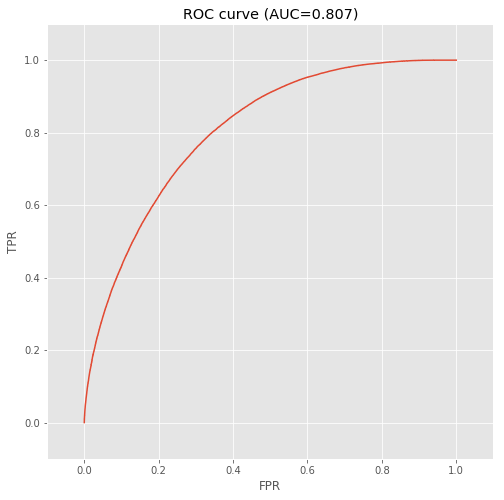

0.8072359748642353

In [23]:
calculate_score_on_dataset_and_show_graph(x_validation, y_validation, model)

In [24]:
#Above- AUC = 0.807

#Below- Compute & display sample of class probabilities for test feature data set.
 # Class w/ highest probability is taken as score (prediction)
    
probabilities = model.predict_proba(data=x_validation)
print(probabilities[:15, :])

[[0.36397659 0.63602341]
 [0.33852934 0.66147066]
 [0.78520344 0.21479656]
 [0.26281122 0.73718878]
 [0.36016889 0.63983111]
 [0.61715569 0.38284431]
 [0.30074776 0.69925224]
 [0.70196905 0.29803095]
 [0.25471573 0.74528427]
 [0.82913968 0.17086032]
 [0.94824026 0.05175974]
 [0.26076449 0.73923551]
 [0.23221889 0.76778111]
 [0.97904073 0.02095927]
 [0.34442076 0.65557924]]


In [25]:
#Above- 1st column= probability of score 0, 2nd column= prob of score 1.

#Below- Transform class probabilities into class scores.
 # Set threshold to prob b/w 2 likelihoods at 0.5. This is applied to prob of score 0 below.
    
def score_model(probs, threshold):
    return np.array([1 if x> threshold else 0 for x in probs[:, 1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_validation[:15])


[1 1 0 1 1 0 1 0 1 0 0 1 1 0 1]
[0 0 1 0 1 0 1 0 1 0 0 0 1 0 0]


In [26]:
# ReCheck accuracy by the equal provided by DrivenData

N = len(y_validation)
print(N)

def isEqual(a):
    return a[0] == a[1]

ClRt = (1/N)*sum(1 for i in filter(isEqual, zip(scores, y_validation)))
print(ClRt)

150000
0.7287266666666666


In [28]:
import sklearn.metrics as sklm

#Below- Compute a confusion matrix as a metric to evaluate the results for the logisitic regression model
 #True Positive (TP)- cases w/ positive labels which have been correctly classified as positive
 #True Negative (TN)- cases w/ negative labels which have been correctly classified as negative
 #False Positive (FP)- cases w/ negative labels which have been incorrectly classified as positive
 #False Negative (FN)- cases w/ positive labels which have been incorrectly classified as negative
 # where positive is 1 and neagtive is 0
    
 #Accuracy/Bias- fraction of cases correctly classified
 #Precision- fraction of correctly calssified label cases out of all cases classified w/ that label value
   # is sentistive to the # of cases correctly classified for a given score value
 #Recall- fraction of cases of a label value correctly classified out of all cases for that have that label value
   # is sensitive to the # of cases correctly classified for a given true label value
 #F1- weighted average of precision and recall (overall model performance)
 #ROC- (receiver operating characteristic) displays relationship b/w TP rate on y and FP rate on x
 #AUC- (area/integral under the curve) overall performance of classifer model
   # higher the AUC, the lower the increase in FP rate req to achieve a req TP rate
     # Ideally AUC= 1.0, TP rate is achieved w/ 0 FP rate.
     # can compare classifiers, one w/ higher AUC is generally better
     # ROC diagonal for Bernoulli w/ AUC 0.5, anything greater than this is better than random guessing in balanced cases
    
#Below- Compute & examine the performance metrics for the classifier using precision_recall_fscore_support 
 # & accuracy_score functions from metric package in scikit-learn. Confusion matrix is computed through 
 # confusion_matrix from same package.

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion Matrix ')
    print('                 Score Positive     Score Negative ')
    print('Actual Positive    %6d' % conf[0, 0] + '              %5d' % conf[0, 1])
    print('Actual Negative    %6d' % conf[1, 0] + '              %5d' % conf[1, 1])
    print('')
    print('Accuracy   %0.2f' % sklm.accuracy_score(labels, scores))
    print('')
    print('            Positive     Negative')
    print('Num Case    %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision   %6.2f' % metrics[0][0] + '        %6.2f' % metrics [0][1])
    print('Recall      %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1          %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][0])
    
    
print_metrics(y_validation, scores)

                 Confusion Matrix 
                 Score Positive     Score Negative 
Actual Positive     50210              24744
Actual Negative     15947              59099

Accuracy   0.73

            Positive     Negative
Num Case     74954         75046
Precision     0.76          0.70
Recall        0.67          0.79
F1            0.71          0.71


In [29]:
# Check probabilities for predictions

print(model.predict_proba(data=x_predict))

[[0.20295785 0.79704215]
 [0.29073742 0.70926258]
 [0.9985872  0.0014128 ]
 ...
 [0.70247408 0.29752592]
 [0.47602747 0.52397253]
 [0.35667631 0.64332369]]


In [30]:
# Check scores for predictions

print(model.predict(data=x_predict))

[1. 1. 0. ... 0. 1. 1.]


In [31]:
Y_PREDICT = model.predict(data=x_predict)

In [32]:
print(Y_PREDICT)

[1. 1. 0. ... 0. 1. 1.]


In [33]:
Y_PREDICT_df = pd.DataFrame(Y_PREDICT)

In [34]:
# Save data to csv for submission

Y_PREDICT_df.to_csv('A3c2d1_CatBoost-Tuning-Classification-Brad_2019-04-23.csv', index = False, header = True)

In [35]:
# Get Feature Importances

model.get_feature_importance(prettified=True)

[('7', 31.969203840903987),
 ('14', 20.79438633686442),
 ('2', 9.261538025703155),
 ('20', 8.188898040417005),
 ('5', 5.14408700656644),
 ('0', 2.8466313496544466),
 ('19', 2.8374428136509544),
 ('18', 2.7154513441827572),
 ('13', 2.0213393114365084),
 ('16', 1.9415993387741248),
 ('10', 1.9241535681742974),
 ('8', 1.5331932275501188),
 ('12', 1.4026483977462803),
 ('6', 1.1966451405700114),
 ('21', 1.1218342926879648),
 ('4', 0.9242307719151711),
 ('3', 0.905318512715434),
 ('9', 0.8886511333117789),
 ('15', 0.836594106842611),
 ('11', 0.5246726349218762),
 ('1', 0.5212765739212017),
 ('17', 0.5002042314894234)]

In [36]:
# Score & display performance metrics for test dataset model

import sklearn.metrics as sklm

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion Matrix')
    print('                 Score Positive    Score Negative')
    print('Actual Positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual Negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro Precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro Recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num Case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    
probabilities = model.predict_proba(x_validation)
print_metrics(y_validation, probabilities, 0.5)     

                 Confusion Matrix
                 Score Positive    Score Negative
Actual Positive     50210             24744
Actual Negative     15947             59099

Accuracy        0.73
AUC             0.81
Macro Precision 0.73
Macro Recall    0.73
 
           Positive      Negative
Num Case    74954         75046
Precision    0.76          0.70
Recall       0.67          0.79
F1           0.71          0.74
